## Содержание

1  Импорты 

2  Знакомство с данными 

3  Предобработка

4  Подготовка

5  Модели

6  Подбор параметров

7  Проверка модели

# Задача по прогнозированию победителя по картам

## 1  Импорты 

Загрузила библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## 2  Знакомство с данными 

In [2]:
try:
    train = pd.read_csv('Downloads/train.csv')
    players_feats = pd.read_csv('Downloads/players_feats.csv')
    test = pd.read_csv('Downloads/test.csv')
except:
    train = pd.read_csv('/Downloads/train.csv')
    players_feats = pd.read_csv('/Downloads/players_feats.csv')
    test = pd.read_csv('/Downloads/test.csv')

In [3]:
train.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB


In [5]:
players_feats.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,...,104,62,49,1.27,1.10,79.0,17.4,7532,Dust2,583
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,...,19,27,25,1.08,1.08,81.5,16.2,4608,Dust2,439


In [6]:
players_feats.describe()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_id
count,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,...,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1486.000000,1482.000000,1486.000000,1486.000000,1486.000000
mean,6808.845222,237.353297,45.623553,239.849260,0.990875,72.572678,5.262988,13.662853,364.810229,0.642517,...,133.167564,14.987214,29.280619,25.924630,1.129105,0.966097,69.634615,13.871400,7461.635262,371.000000
std,4031.792795,126.932320,9.999153,124.403672,0.237200,11.874143,2.626014,6.904256,185.463054,0.122343,...,80.731101,34.329486,19.535033,16.981899,0.583538,0.284628,20.948070,6.240919,2255.926813,214.557636
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4411.000000,0.000000
25%,3669.000000,148.000000,41.000000,156.000000,0.870000,66.600000,3.500000,9.000000,237.250000,0.580000,...,77.000000,-5.000000,15.000000,13.000000,0.800000,0.900000,66.700000,10.525000,5752.000000,185.250000
50%,7938.000000,224.000000,46.700000,227.000000,0.960000,72.500000,4.800000,13.000000,347.000000,0.640000,...,129.000000,7.000000,27.000000,24.000000,1.060000,1.000000,74.250000,13.800000,7020.000000,371.000000
75%,9115.000000,307.000000,51.100000,310.750000,1.080000,78.975000,6.600000,18.000000,476.000000,0.690000,...,184.000000,33.000000,42.000000,36.000000,1.380000,1.110000,81.075000,17.700000,9455.000000,556.750000
max,14359.000000,769.000000,81.800000,711.000000,3.890000,152.400000,21.000000,41.000000,1097.000000,1.670000,...,385.000000,165.000000,102.000000,96.000000,5.000000,2.150000,100.000000,50.000000,11726.000000,742.000000


In [7]:
players_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Columns: 128 entries, p1_id to map_id
dtypes: float64(80), int64(47), object(1)
memory usage: 1.5+ MB


In [8]:
df_test = test.drop(columns = ['index'], axis = 1)
df_test.head()

,map_id,team1_id,team2_id,map_name
0,309,5973,5752,Dust2
1,541,5973,5752,Vertigo
2,1,8297,7020,Nuke
3,392,8297,7020,Mirage
4,684,8297,7020,Overpass


## 3  Предобработка

Объеденим датасеты

In [9]:
df = train.merge(players_feats, on='map_id', how='left')
df_test = df_test.merge(players_feats, on='map_id', how='left')


In [10]:
df.head()

,map_id,team1_id,team2_id,map_name_x,who_win,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,...,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name_y
0,289,6665,7718,Ancient,0,4954,258,36.0,293,0.88,...,210,55,55,33,1.67,1.18,83.6,19.7,6665,Ancient
1,289,6665,7718,Ancient,0,8371,126,46.0,117,1.08,...,75,-34,21,20,1.05,1.06,76.2,19.0,7718,Ancient
2,715,4411,10577,Inferno,0,8611,178,39.3,208,0.86,...,186,-23,47,49,0.96,1.01,74.5,16.3,4411,Inferno
3,715,4411,10577,Inferno,0,8488,523,53.0,525,1.00,...,197,90,64,25,2.56,1.39,75.0,23.3,10577,Inferno
4,157,11251,9455,Nuke,1,7938,494,52.8,397,1.24,...,150,8,11,21,0.52,0.73,81.8,5.0,11251,Nuke


Проверила на модели,map_name_x и map_name_y мало влияют 
Удалила


In [11]:
df.describe(include='object')

,map_name_x,map_name_y
count,1426,1426
unique,7,7
top,Mirage,Mirage
freq,236,236


In [12]:
df = df.drop(columns = ['map_name_x','map_name_y'], axis = 1)
df_test = df_test.drop(columns = ['map_name_x','map_name_y'], axis = 1)

In [13]:
df = df.drop(columns = ['p5_first_kill_in_won_rounds','p4_grenade_damage_per_round', 'p4_damage_per_round',
                        'p5_deaths_per_round','p4_deaths_per_round','p5_team_win_percent_after_first_kill',
                        'p1_grenade_damage_per_round', 'p1_damage_per_round','p2_headshots',
                        'p1_kd_ratio', 'p4_kd_ratio', 'p1_total_deaths', 'p5_saved_by_teammate_per_round'], axis = 1)
df_test = df_test.drop(columns =  ['p5_first_kill_in_won_rounds','p4_grenade_damage_per_round', 'p4_damage_per_round',
                        'p5_deaths_per_round','p4_deaths_per_round','p5_team_win_percent_after_first_kill',
                        'p1_grenade_damage_per_round', 'p1_damage_per_round','p2_headshots',
                        'p1_kd_ratio', 'p4_kd_ratio', 'p1_total_deaths', 'p5_saved_by_teammate_per_round'], axis = 1)                            

Удалила пропуски

In [14]:
df = df.dropna()

In [15]:
df.duplicated().sum()

0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413 entries, 0 to 1425
Columns: 117 entries, map_id to team_id
dtypes: float64(68), int64(49)
memory usage: 1.3 MB


In [17]:
df.describe()

,map_id,team1_id,team2_id,who_win,p1_id,p1_total_kills,p1_headshots,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,team_id
count,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,...,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000,1413.000000
mean,371.033970,7236.681529,7775.423213,0.457891,6801.577495,237.330502,45.643029,13.666667,364.922151,0.641748,...,1.090474,1.018528,0.642463,132.607926,14.694975,29.135173,25.854211,1.127665,0.963355,7512.163482
std,215.088358,2188.859455,2314.013618,0.498400,4065.025706,127.989516,10.124161,6.976793,187.193155,0.123189,...,0.147385,0.320066,0.183683,80.169283,33.337377,19.322505,17.024353,0.586706,0.287139,2268.848180
min,0.000000,4411.000000,4411.000000,0.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-87.000000,0.000000,0.000000,0.000000,0.000000,4411.000000
25%,183.000000,5005.000000,5973.000000,0.000000,2898.000000,148.000000,41.000000,9.000000,236.000000,0.580000,...,1.010000,0.930000,0.610000,76.000000,-5.000000,15.000000,13.000000,0.800000,0.900000,5752.000000
50%,371.000000,6667.000000,7532.000000,0.000000,7805.000000,223.000000,46.800000,13.000000,346.000000,0.640000,...,1.100000,1.060000,0.680000,128.000000,7.000000,27.000000,24.000000,1.060000,1.000000,7020.000000
75%,557.000000,9215.000000,9565.000000,1.000000,9115.000000,308.000000,51.200000,18.000000,477.000000,0.690000,...,1.180000,1.180000,0.730000,184.000000,33.000000,41.000000,36.000000,1.380000,1.110000,9565.000000
max,742.000000,11726.000000,11726.000000,1.000000,14359.000000,769.000000,81.800000,41.000000,1097.000000,1.670000,...,1.650000,3.000000,1.230000,385.000000,139.000000,96.000000,96.000000,5.000000,2.150000,11726.000000


## 4  Подготовка

Поделила на выборки

In [18]:
df_train, df_valid= np.split(df, [int(.7*len(df))])
display(df_train.shape)
display(df_valid.shape)

(989, 117)

(424, 117)

Выделила целевой признак

In [19]:
features_train = df_train.drop(['who_win'], axis=1)
target_train = df_train['who_win']
features_valid = df_valid.drop(['who_win'], axis=1)
target_valid = df_valid['who_win']

In [20]:
target_train.mean()

0.46006066734074824

In [21]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)


 ## 5 Подбор модели

'Лучшее значение roc_auc:'

0.5846915409482758

10

1

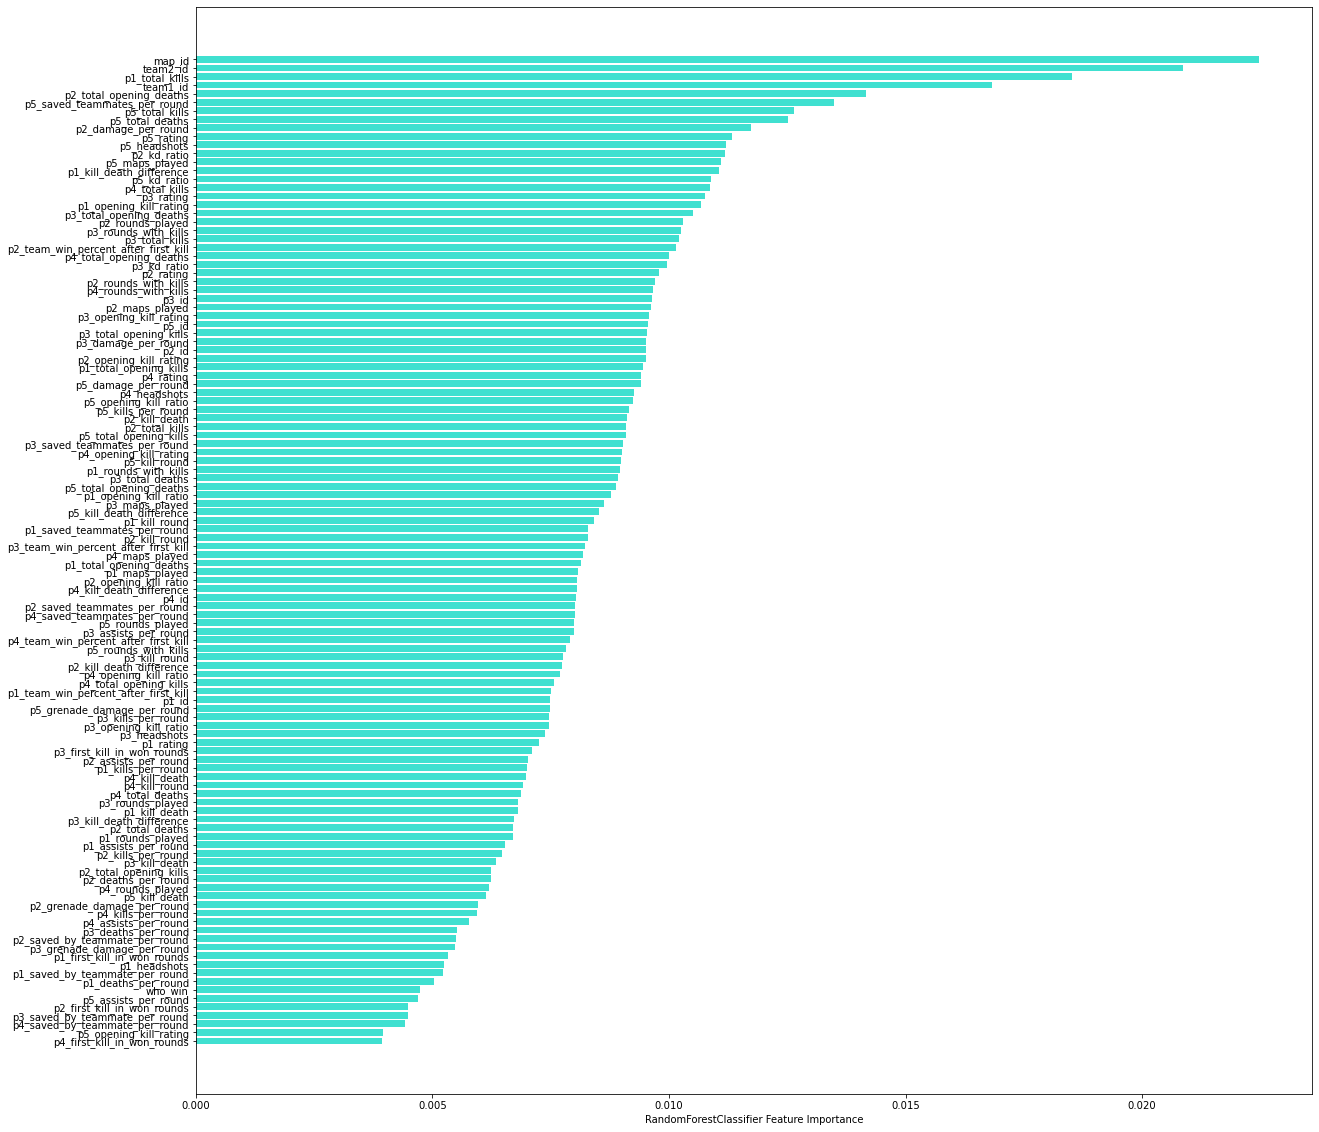

In [22]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0
for est in range(10, 100, 10):
    for depth in range (1, 12):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model.fit(features_train, target_train) 
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        result = roc_auc_score(target_valid, probabilities_one_valid) 
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

display("Лучшее значение roc_auc:", best_result, best_est, best_depth)

sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForestClassifier Feature Importance")
plt.show()

In [23]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("auc_roc:", auc_roc)

'auc_roc:'

0.5916846264367817

'Лучшее значение roc_auc:'

0.550579202586207

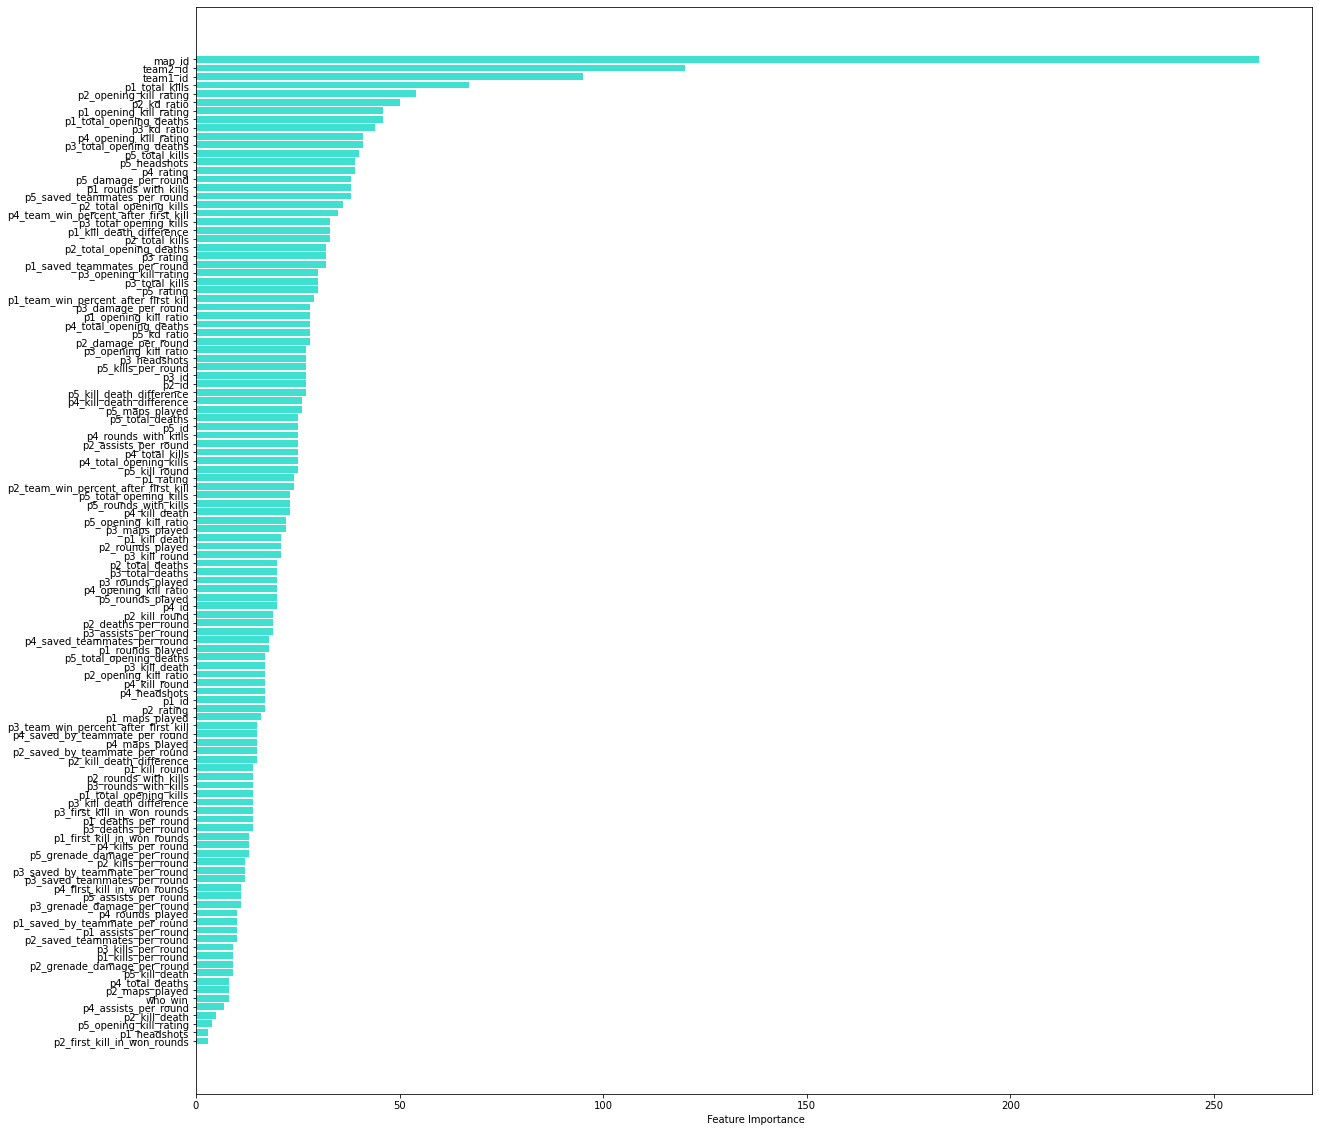

In [24]:
model = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1,
                           learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                           objective=None, class_weight=None, min_split_gain=0.0,
                           min_child_weight=0.001, min_child_samples=20,
                           subsample=1.0, subsample_freq=0, colsample_bytree=1.0,
                           reg_alpha=0.0, reg_lambda=0.0, random_state=12345, n_jobs=- 1,
                           importance_type='split')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("Лучшее значение roc_auc:", auc_roc)

sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel(" Feature Importance")
plt.show()

Learning rate set to 0.010254
0:	learn: 0.6922950	total: 165ms	remaining: 2m 45s
10:	learn: 0.6848634	total: 323ms	remaining: 29.1s
20:	learn: 0.6774283	total: 477ms	remaining: 22.2s
30:	learn: 0.6714222	total: 645ms	remaining: 20.2s
40:	learn: 0.6651194	total: 805ms	remaining: 18.8s
50:	learn: 0.6584917	total: 984ms	remaining: 18.3s
60:	learn: 0.6524098	total: 1.14s	remaining: 17.6s
70:	learn: 0.6460682	total: 1.31s	remaining: 17.1s
80:	learn: 0.6401465	total: 1.48s	remaining: 16.8s
90:	learn: 0.6346176	total: 1.65s	remaining: 16.5s
100:	learn: 0.6293570	total: 1.82s	remaining: 16.2s
110:	learn: 0.6233771	total: 1.99s	remaining: 15.9s
120:	learn: 0.6193686	total: 2.14s	remaining: 15.5s
130:	learn: 0.6154879	total: 2.3s	remaining: 15.3s
140:	learn: 0.6110813	total: 2.46s	remaining: 15s
150:	learn: 0.6064766	total: 2.61s	remaining: 14.7s
160:	learn: 0.6024655	total: 2.77s	remaining: 14.4s
170:	learn: 0.5984433	total: 2.93s	remaining: 14.2s
180:	learn: 0.5943321	total: 3.08s	remaining: 1

'Лучшее значение roc_auc:'

0.5452586206896552

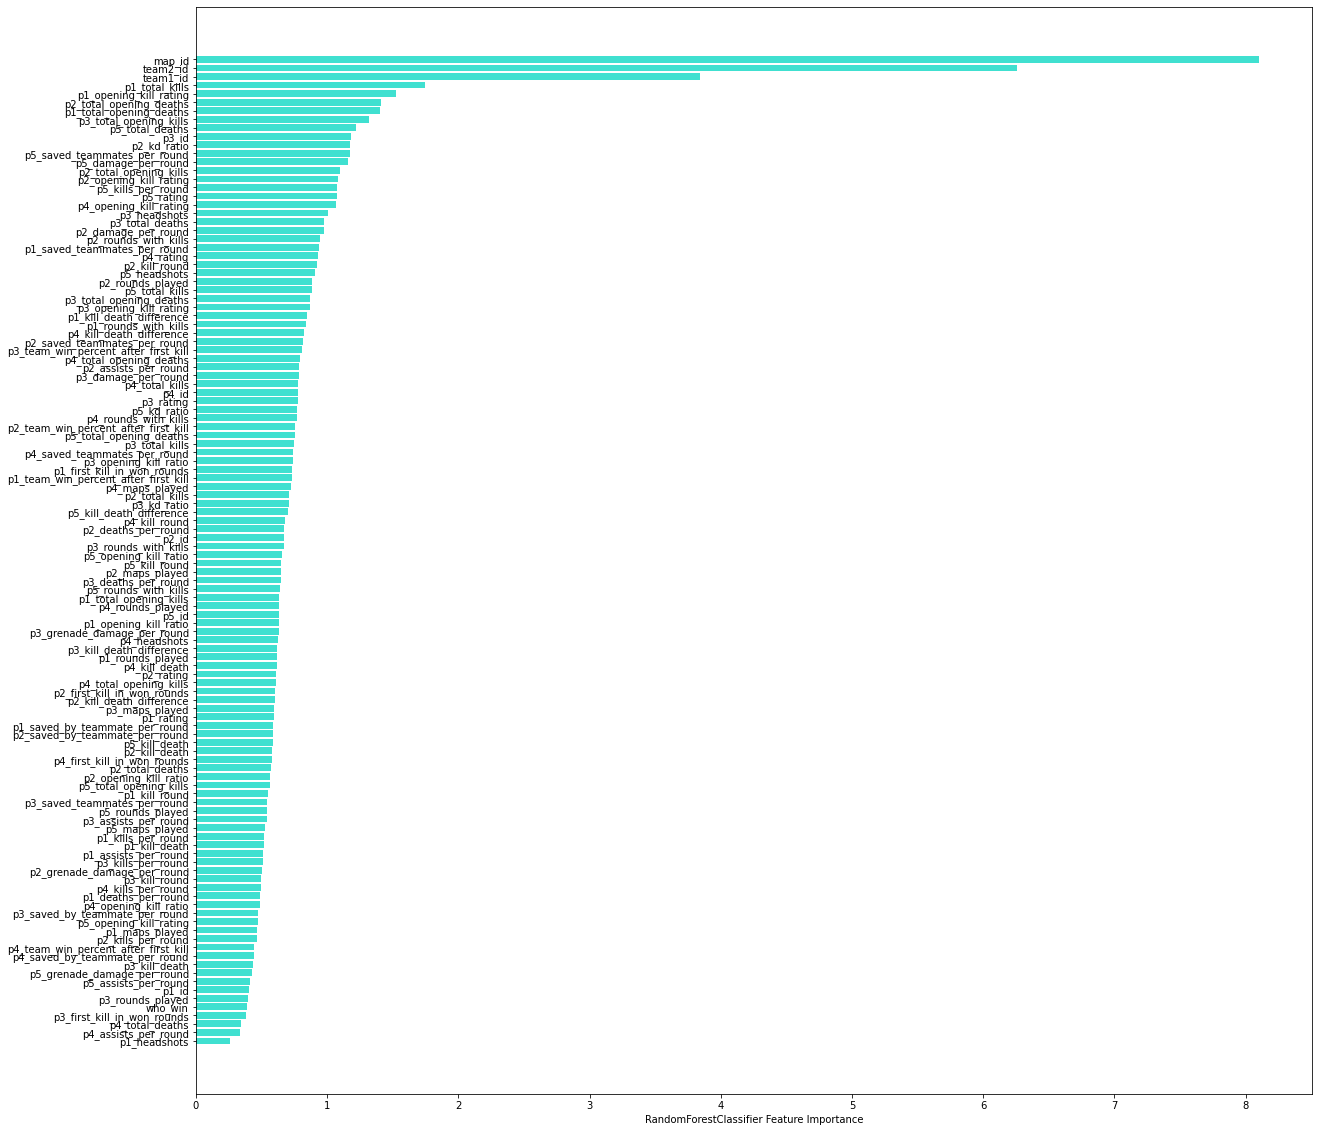

Wall time: 18.7 s


In [25]:
%%time
model = CatBoostClassifier(random_state=12345)
model.fit(features_train, target_train, verbose=10)
predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("Лучшее значение roc_auc:", auc_roc)


sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("RandomForestClassifier Feature Importance")
plt.show()

'Лучшее значение roc_auc:'

0.5540364583333334

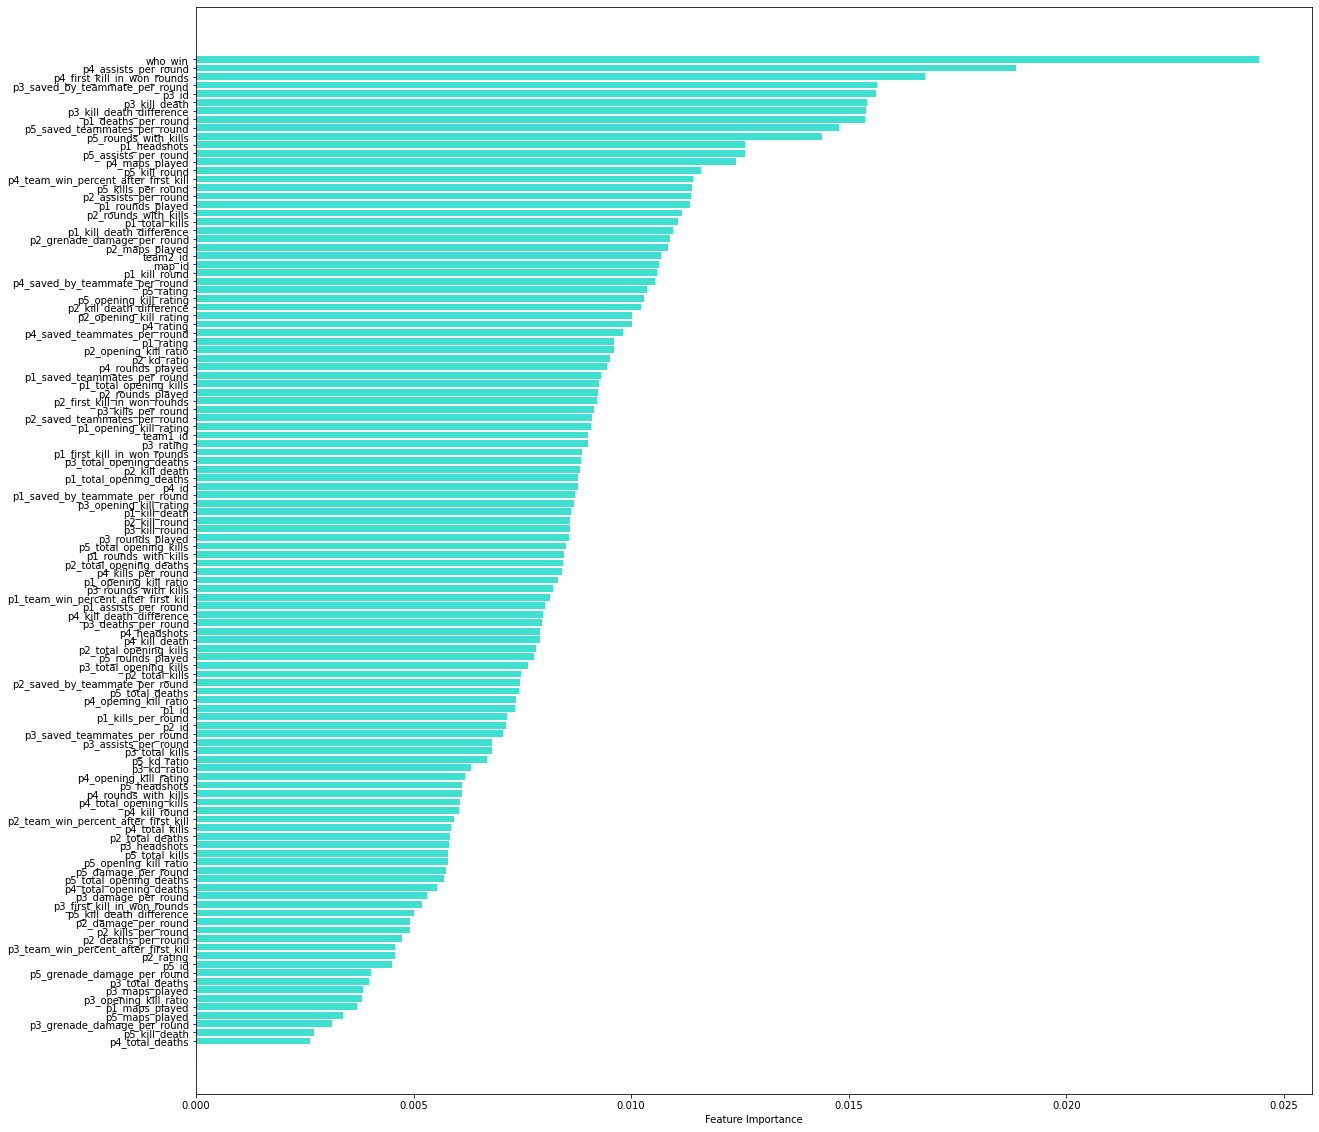

In [26]:
model = XGBClassifier(random_state=12345)
model.fit(features_train, target_train, verbose=10)
predicted_valid = model.predict(features_valid) 

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display("Лучшее значение roc_auc:", auc_roc)


sorted_feature_importance = model.feature_importances_.argsort()
plt.figure(figsize=(20, 20))
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("Feature Importance")
plt.show()

## 6 Подбор параметров

In [27]:
def grid_search(model,params,scoring,features,target):
    model_random = GridSearchCV(model,params,cv=5, n_jobs=-1,scoring=scoring)
    model_random.fit(features,target)
    best_params_random = model_random.best_params_
    best_score_random = model_random.best_score_
    return model_random,best_params_random,best_score_random

In [31]:
#Cat_params = {'iterations': range(1,20), 'depth': range(1,10)}

In [32]:
#model_random1,best_params_random1,best_score_random1 = grid_search(CatBoostClassifier(random_state=12345),Cat_params,'roc_auc',features_train,target_train)

In [33]:
#model_random1,best_params_random1,best_score_random1

## 7 Проверка модели

In [34]:
df_test1 = df_test

In [35]:
model = XGBClassifier(random_state=12345)
model.fit(features_train, target_train, verbose=10)
predicted_test = model.predict(df_test)

probabilities_valid = model.predict_proba(df_test)
probabilities_one_valid = probabilities_valid[:, 1]
df_test1['who_won'] = predicted_test
df_test1['who_won'].head()


0    1
1    1
2    1
3    1
4    1
Name: who_won1, dtype: int32

In [39]:
model = CatBoostClassifier(random_state=12345, depth = 3, iterations = 2)
model.fit(features_train, target_train, verbose=10)
predicted_test = model.predict(df_test)

probabilities_valid = model.predict_proba(df_test)
probabilities_one_valid = probabilities_valid[:, 1]
df_test1['who_won1'] = predicted_test
df_test1['who_won1'].head()


Learning rate set to 0.5
0:	learn: 0.6839149	total: 4.02ms	remaining: 4.02ms
1:	learn: 0.6694824	total: 8.45ms	remaining: 0us


0    1
1    1
2    1
3    1
4    1
Name: who_won2, dtype: int64

In [37]:
df_test1['who_won1'].to_csv('who_won1')

